In [1]:
# https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import seaborn as sns

# Compartmental model

We are using a compartmental epidemiological that is a variation of the SEIR model.

We have introduced variations into order to model population heterogeneity.

## SEIR model

In this model, the individuals are either **Susceptible**, **Exposed**, **Infectious**, or **Recovered** (or Removed). We use $S$, $E$, $I$, and $R$ to denote the number of individuals in each compartment and $N$ to denote the total population.

There are several model parameters:

 * $\beta$, the average number of contacts by an individual per time step multiplied by the probability of disease transmission between an susceptible and infectious person.
 * $\alpha$, the inverse of the mean of the (exponentially distributed) incubation period for the disease
 * $\gamma$, the inverse of the mean of the (exponentially distributed) infectious period for the disease
 
Then the dynamic equations are:

[//]: # "Use better latex to line up equations here"
 
$\frac{dS}{dt} = - \beta \frac{I}{N} S$

$\frac{dE}{dt} = \beta \frac{I}{N} S - \alpha E$

$\frac{dI}{dt} = \alpha E - \gamma I$

$\frac{dR}{dt} = \gamma I$

In [2]:
# The SEIR model differential equations.
def SEIR_deriv(y, t, N, beta, alpha, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

We will set some parameters to use throughout this notebook

In [3]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
E0, I0, R0 = 0, 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - E0 - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, alpha, gamma = 0.2, 2./10, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

Using these equations we can simulate the model.

In [4]:
# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SEIR equations over the time grid, t.
ret = odeint(SEIR_deriv, y0, t, args=(N, beta, alpha, gamma))
S, E, I, R = ret.T

S_benchmark = S

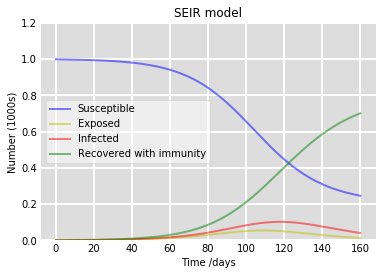

In [5]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, E/1000, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title('SEIR model')
plt.show()

In [6]:
# Shortcut to computing the former
def SEIR_test(beta,alpha,gamma):
    ret = odeint(SEIR_deriv, y0, t, args=(N, beta, alpha, gamma))
    return ret.T

## SkEIR model with S, $\beta$ heterogeneity (Dolbeault & Turinici, 2020)

A challenge for compartmental epidemiological models is that while modeling population heterogeneity is of increasing relevance for modeling diseases like COVID-19, this is not "native" to this modeling technique. Like other fields, compartmental epidemiology tends to use a 'representative agent' model.

Here, we consider heterogeneity in contacts by an individual per time step, which is a factor in the definition of $\beta$:

 * $\beta$, the average number of contacts by an individual per time step multiplied by the probability of disease transmission between an susceptible and infectious person.

The Dolbeault & Turinici (2020) has shown that, contrary to the assumption within this definition, the "average number of contacts by an individual per time step" is perhaps not straightforwardly calculated, or accurate? It considers a "factor of reduction in contacts" $q$, which is differentiated for $n$ classes, $q_0, q_1, ..., q_n$. They then define:

$$\beta_k = \beta / q_k$$

They then use a model where several different classes of _susceptibles_ : $ S = \sum_k p_k S_k$, with $1 = \sum_k p_k$

Then the dynamic equations are:

[//]: # "Use better latex to line up equations here"
 
$\frac{dS_k}{dt} = - \beta_k \frac{I}{N} S$

$\frac{dE}{dt} = \sum^{n}_{k=1} \beta_k \frac{I}{N} S_k - \alpha E$

$\frac{dI}{dt} = \alpha E - \gamma I$

$\frac{dR}{dt} = \gamma I$

The authors compare models of this kind to the original SEIR models that have the same $\mathcal{R}_0$.

Following those authors, we will try to replicate their results with two classed $n = 2$.

In [7]:
type(np.zeros(1))

numpy.ndarray

In [8]:
# The SEIR model differential equations.
def SkEIR_deriv(y, t, N, beta : np.ndarray, alpha, gamma):
    S_0, S_1, E, I, R = y
    
    dS0dt = - beta[0] * S_0 * I / N
    dS1dt = - beta[1] * S_1 * I / N
    
    dEdt = (beta[0] * S_0 + beta[1] * S_1) * I / N - alpha * E

    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    return dS0dt, dS1dt, dEdt, dIdt, dRdt

In [9]:
p = np.array([.5, .5])

Sk0 = p * S0
beta = np.array([0.1,.3])

# Initial conditions vector
yk0 = Sk0[0], Sk0[1], E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SkEIR_deriv, yk0, t, args=(N, beta, alpha, gamma))
S_0, S_1 , E, I, R = ret.T

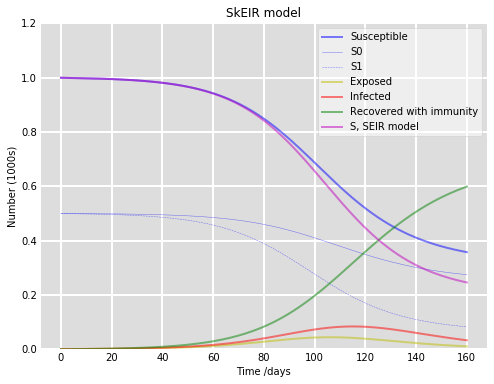

In [10]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w',figsize=(8,6))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, (S_0 + S_1)/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, (S_0)/1000, 'b', alpha=0.5, lw=.5, label='S0')
ax.plot(t, (S_1)/1000, 'b--', alpha=0.5, lw=.5, label='S1')
ax.plot(t, E/1000, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, (S)/1000, 'm', alpha=0.5, lw=2, label='S, SEIR model')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title('SkEIR model')
plt.show()

Though $\sum_k p_k \beta_k = \beta$, the outcomes of this model and the previous one diverge greatly. This is a bit of a mystery, as the $\mathcal{R}_0$ are the same. But the breakdown of the `S0` and `S1` groups shows what's happening: the total susceptible count is the sum of two differently effected subsystems.

### Hypothesis: Wrong mean formula

One idea: maybe the discrepancy here is due to the use of the wrong mean.

This can be tested quickly.

In [11]:
import math
import statistics

In [12]:
S_harmonic = SEIR_test(statistics.harmonic_mean(1 + beta) - 1,
                       alpha,
                       gamma)[0]
S_geometric = SEIR_test(math.sqrt((beta[0] + 1) * (beta[1] + 1)) - 1,
                        alpha,
                        gamma)[0]

(I did some work and disproved this hypothesis.)

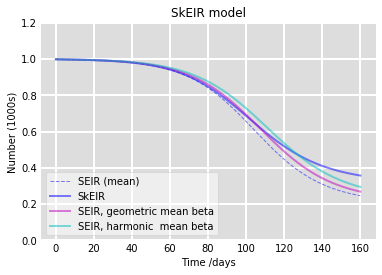

In [13]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, (S_benchmark)/1000, 'b--', alpha=0.5, lw=1, label='SEIR (mean)')
ax.plot(t, (S_0 + S_1)/1000, 'b', alpha=0.5, lw=2, label='SkEIR')
ax.plot(t, S_geometric/1000, 'm', alpha=0.5, lw=2, label='SEIR, geometric mean beta')
ax.plot(t, S_harmonic/1000, 'c', alpha=0.5, lw=2, label='SEIR, harmonic  mean beta')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title('SkEIR model')
plt.show()

This is a false path.

## SEIkR model with I, $\beta$ heterogeneity

Our (Benthall, Epstein, Hatna, and Strandburg) model (in NetLogo) thus far is a bit different.

We have been assigning different transmission probabilities to different _infectors_ in order to model the phenomenon of _superspreaders_.

Rendered as a compartmental model, this has different equations from D&T 2020.

Here, $\sum_k p_k = 1$ and represents the proportion of different categories of infectors.

 
$\frac{dS}{dt} = - \sum_k \beta_k \frac{I_k}{N} S$

$\frac{dE}{dt} = \sum_k \beta_k \frac{I_k}{N} S - \alpha E$

$\frac{dI_k}{dt} = p_k \alpha E - \gamma I_k$

$\frac{dR}{dt} = \sum_k \gamma I_k$

In [14]:
# The SEIR model differential equations.
def SEIkR_deriv(y, t, N, beta : np.ndarray, alpha, gamma, p : np.ndarray):
    S_0, S_1, E_0, E_1, I_0, I_1, R = y
    
    dSdt = - (beta[0] * I_0 + beta[1] * I_1) * S / N
    
    dEdt = (beta[0] * I_0 + beta[1] * I_1) * S / N - alpha * E

    dI0dt = p[0] * alpha * E - gamma * I_0
    dI1dt = p[1] * alpha * E - gamma * I_1
    dRdt = gamma * I_0 + gamma * I_1
    return dSdt, dEdt, dI0dt, dI1dt, dRdt

In [15]:
### I messed this up!!!

p = np.array([.5, .5])

beta = 0.2

I0k = I0 * p

# Initial conditions vector
yk0 = S0, E0, I0k[0], I0k[1], R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SEIkR_deriv, yk0, t, args=(N, beta, alpha, gamma, p))
S, E, I_0, I_1, R = ret.T

ValueError: not enough values to unpack (expected 7, got 5)

In [ ]:
E

In [ ]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w',figsize=(8,6))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, E/1000, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, (I_0 + I_1)/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, (I_0)/1000, 'r', alpha=0.5, lw=.5, label='I_0')
ax.plot(t, (I_1)/1000, 'r--', alpha=0.5, lw=.5, label='I_1')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, (S_benchmark)/1000, 'm--', alpha=0.5, lw=2, label='S, SEIR model')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title('SEIkR model')
plt.show()

Note hear that with the SEIkR model, we get identical performance of the model when $\beta = \sum_k p_k \beta_k$ as originally proposed by Hatna. This suggests that our model is better than D & T 2020.

But why were we not able to replicate this in the ABM?

## SkEkIkR model with I, $\gamma$ heterogeneity and $p$ blending

Our (Benthall, Hatna, Epstein and Strandburg) Watts-Strogatz model (in Python) is different still.

Assume that the population is divided into $k = 2$ compartments.
When somebody infects another, it is a local infection with probability $(1 - p) + p / 2$.
If it is a local infection, then the same compartment is infected.
If it is a distant infection, which happens with probability $p / 2$, then the other compartment is infected.

Here, $p$ is the rewiring rate of the notional Watts-Strogatz model.

Let $\hat{p} = p / 2$.

The two compartments vary in their recovery rate $\gamma$. Here, we include quarantine due to contact tracing and testing as a form of recovery. So varying $\gamma$ reflects the difference in adoption of smartphone based contact tracing in the two compartments.

 
$\frac{dS_k}{dt} = - \beta \frac{(1 - \hat{p}) I_k + \hat{p} I_{\neg k}}{(N / 2)} S_k$

$\frac{dE_k}{dt} = \beta \frac{(1 - \hat{p}) I_k + \hat{p} I_{\neg k}}{(N / 2)} S_k - \alpha E_k$

$\frac{dI_k}{dt} = \alpha E_k - \gamma_k I_k$

$\frac{dR}{dt} = \sum_k \gamma_k I_k$

In [24]:
# The SEIR model differential equations.
def SkEkIkR_deriv(y, t, N, beta, alpha, gamma : np.ndarray, p_hat):
    S_0, S_1, E_0, E_1, I_0, I_1, R = y
    
    dS0dt = - beta * ((1 - p_hat) * I_0 + (p_hat) * I_1) * S_0 / Nk[0]
    dS1dt = - beta * ((p_hat) * I_0 + (1 - p_hat) * I_1) * S_1 / Nk[1]
    
    dE0dt = beta * ((1 - p_hat) * I_0 + (p_hat) * I_1) * S_0 / Nk[0] - alpha * E_0
    dE1dt = beta * ((p_hat) * I_0 + (1 - p_hat) * I_1) * S_1 / Nk[1] - alpha * E_1

    dI0dt = alpha * E_0 - gamma[0] * I_0
    dI1dt = alpha * E_1 - gamma[1] * I_1
    
    dRdt = gamma[0] * I_0 + gamma[1] * I_1
    
    return dS0dt, dS1dt, dE0dt, dE1dt, dI0dt, dI1dt, dRdt

In [39]:
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

p_hat = .125
p = np.array([.5, .5])

# compartmentalized population
Nk = N * p


Ek0 = 0 * p
Ik0 = 1 * p
R0 = 0

Sk0 = Nk - Ek0 - Ik0 - R0

beta = 0.2
alpha = 0.2
x = .02
gamma = [beta / 2 - x, beta / 2 + x]

# Initial conditions vector
yk0 = Sk0[0], Sk0[1], Ek0[0], Ek0[1], Ik0[0], Ik0[1], R0

# Integrate the SIR equations over the time grid, t.
ret = odeint(SkEkIkR_deriv, yk0, t, args=(Nk, beta, alpha, gamma, p_hat))
S_0, S_1, E_0, E_1, I_0, I_1, R = ret.T

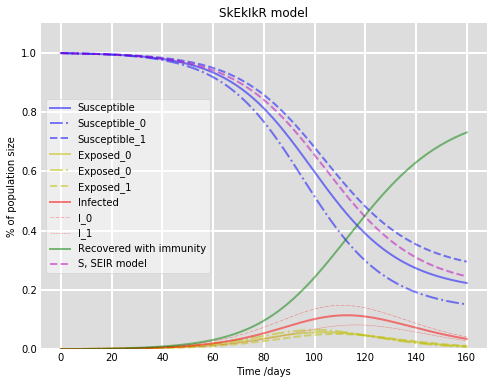

In [44]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w',figsize=(8,6))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, (S_0 + S_1) / N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, S_0/Nk[0], 'b-.', alpha=0.5, lw=2, label='Susceptible_0')
ax.plot(t, S_1/Nk[1], 'b--', alpha=0.5, lw=2, label='Susceptible_1')
ax.plot(t, (E_0 + E_1)/N, 'y-', alpha=0.5, lw=2, label='Exposed_0')
ax.plot(t, E_0/Nk[0], 'y-.', alpha=0.5, lw=2, label='Exposed_0')
ax.plot(t, E_1/Nk[1], 'y--', alpha=0.5, lw=2, label='Exposed_1')
ax.plot(t, (I_0 + I_1)/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, (I_0)/Nk[0], 'r-.', alpha=0.5, lw=.5, label='I_0')
ax.plot(t, (I_1)/Nk[1], 'r--', alpha=0.5, lw=.5, label='I_1')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, (S_benchmark)/ N, 'm--', alpha=0.5, lw=2, label='S, SEIR model')
ax.set_xlabel('Time /days')
ax.set_ylabel('% of population size')
ax.set_ylim(0,1.1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title('SkEkIkR model')
plt.show()

In [48]:
def results(p_hat, gamma):

    # A grid of time points (in days)
    t = np.linspace(0, 160, 160)

    p = np.array([.5, .5])

    # compartmentalized population
    Nk = N * p

    Ek0 = 0 * p
    Ik0 = 1 * p
    R0 = 0

    Sk0 = Nk - Ek0 - Ik0 - R0

    beta = 0.2
    alpha = 0.25
    gamma = gamma

    # Initial conditions vector
    yk0 = Sk0[0], Sk0[1], Ek0[0], Ek0[1], Ik0[0], Ik0[1], R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(SkEkIkR_deriv, yk0, t, args=(Nk, beta, alpha, gamma, p_hat))
    
    # S_0, S_1, E_0, E_1, I_0, I_1, R 
    return ret.T

In [49]:
np.linspace(0,.1,20)

array([0.        , 0.00526316, 0.01052632, 0.01578947, 0.02105263,
       0.02631579, 0.03157895, 0.03684211, 0.04210526, 0.04736842,
       0.05263158, 0.05789474, 0.06315789, 0.06842105, 0.07368421,
       0.07894737, 0.08421053, 0.08947368, 0.09473684, 0.1       ])

In [50]:
p_hat = .125

infections = {}

for x in np.linspace(0,.1,20):
    res = results(p_hat, [.1 - x, .1 + x])
    infections[x] = res[4][-1] + res[5][-1]

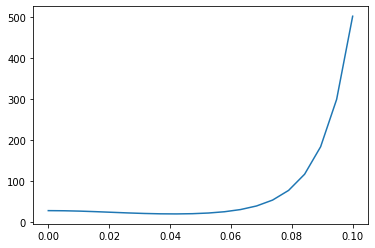

In [51]:
sns.lineplot(data = infections)

## Next steps?

This is veering towards a more complete generalization of the model, in which the transitions between different classes of agents can be parameterized out through $\beta$ and also $\alpha, \gamma$. Quite possibly an approximation of the spatial characteristics of the model can be built in this way.

Consider:
 - a factor for classes of susceptibles that controls the rate of exposure is reflective of that agent's "in-degree" of transmitting contacts.
 - a factor for classes of infectors that controls the rate of infection is reflective of that agent's "out-degree" of transmitting contacts.
 
In principle, each agent could be a member of both a class of susceptibles and a class of infectors, and the parameterized distribution across those classes would enable a wide range of network topologies.

It would also be possible to control how much the groups intermingle by having weighted parameters for each pairwise group interaction. I.e., use matrices for the $\beta, \alpha$ and $\gamma$ parameters, not vectors.

The SEIkR model and the SkEIR model are slightly different in that while the former uses the probabilistic differentiation into classes as weights in the differential equations, the latter uses them to preset the populations as fractions of N.

## References

Dolbeault, J., & Turinici, G. (2020). Social heterogeneity and the COVID-19 lockdown in a multi-group SEIR model. medRxiv.